# Homework 04
---
[mlbookcamp 04-evalutation](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/04-evaluation/homework.md)

In [1]:
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
DIRPATH="./data/"
FILENAME = "CreditCard.csv"
DATAPATH = osp.join(DIRPATH, FILENAME)

### Downloading data

In [6]:
! ./downloading_data.sh -d $DIRPATH -f $FILENAME https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-03 09:02:22--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 73250 (72K) [text/plain]
Salvando em: “./data//CreditCard.csv”

./data//CreditCard. 100%[===================>]  71,53K  --.-KB/s    em 0,03s   

2022-10-03 09:02:23 (2,16 MB/s) - “./data//CreditCard.csv” salvo [73250/73250]



## Preparation
Code available at https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/04-evaluation/homework-4-starter.ipynb

In [7]:
data = pd.read_csv(DATAPATH)
data.columns = data.columns.str.lower()
data.head().T

,0,1,2,3,4
card,yes,yes,yes,yes,yes
reports,0,0,0,0,0
age,37.66667,33.25,33.66667,30.5,32.16667
income,4.52,2.42,4.5,2.54,9.7867
share,0.03327,0.005217,0.004156,0.065214,0.067051
expenditure,124.9833,9.854167,15.0,137.8692,546.5033
owner,yes,no,yes,no,yes
selfemp,no,no,no,no,no
dependents,3,3,4,0,2
months,54,34,58,25,64


Create the target variable by mapping `yes` to `1` and `no` to `0`.

In [10]:
target_card = data.card == 'yes'

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns='card'),
                                                    target_card,
                                                    test_size=0.2,
                                                    random_state=1)

X_train, X_val, Y_train, Y_val = train_test_split(X_train,
                                                Y_train,
                                                test_size=0.25,
                                                random_state=1)

In [34]:
np.round([len(X_train)/len(data), len(X_test)/len(data), len(X_val)/len(data)], 2)

array([0.6, 0.2, 0.2])

## Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the "card" variable
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [35]:
from sklearn.metrics import roc_auc_score

query_features = ['reports', 'dependents', 'active', 'share']
dict_scores = {}
for feature in query_features:
    auc_score = roc_auc_score(Y_train, X_train[feature])
    auc_score = auc_score if auc_score >= 0.5 else roc_auc_score(Y_train, -X_train[feature])
    dict_scores[feature] = auc_score
dict_scores

{'reports': 0.7166629860689376,
 'dependents': 0.5327757227773791,
 'active': 0.6043173411362006,
 'share': 0.989183643423692}

In [36]:
sorted(dict_scores, key=dict_scores.get, reverse=True)

['share', 'reports', 'active', 'dependents']

## Training the model
From now on, use these columns only:
    
    ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

Apply `one-hot-encoding` using `DictVectorizer` and train the logistic regression with these parameters:

    LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [37]:
feature_columnns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

X_train = X_train[feature_columnns]
X_test = X_test[feature_columnns]
X_val = X_val[feature_columnns]

In [38]:
from sklearn.feature_extraction import DictVectorizer

dict_vect = DictVectorizer(sparse=False)
X_train_preprocessed = dict_vect.fit_transform(X_train.to_dict(orient='records'))
X_test_preprocessed = dict_vect.transform(X_test.to_dict(orient='records'))
X_val_preprocessed = dict_vect.transform(X_val.to_dict(orient='records'))

In [39]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_preprocessed, Y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [40]:
yhat = model.predict_proba(X_val_preprocessed)[:, 1]
round(roc_auc_score(Y_val, yhat), 3)

0.995

## Question 3
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

In [41]:
from sklearn.metrics import precision_score, recall_score

yhat_proba = model.predict_proba(X_val_preprocessed)[:, 1]

score_dict = {'threshold': [], 'precision': [], 'recall': []}

for threshold in np.arange(0.0, 1.0, step=0.01):
    yhat = (yhat_proba > threshold) * 1
    score_dict['threshold'].append(threshold)
    score_dict['precision'].append(precision_score(Y_val, yhat, zero_division=0.0))
    score_dict['recall'].append(recall_score(Y_val, yhat, zero_division=.0))

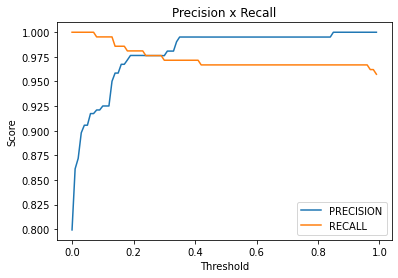

In [42]:
score_df = pd.DataFrame(score_dict).set_index('threshold')
plt.plot(score_df.index, score_df.precision, label='PRECISION')
plt.plot(score_df.index, score_df.recall, label='RECALL')
plt.title('Precision x Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

## Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

 
Where `P` is precision and `R` is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01



At which threshold F1 is maximal?

- `0.1`
- `0.4`
- `0.6`
- `0.7`

In [43]:
score_df['F1'] = 2* (score_df.precision * score_df.recall) / (score_df.precision + score_df.recall)
score_df.sort_values(by='F1', ascending=False)

,precision,recall,F1
threshold,,,
0.35,0.995146,0.971564,0.983213
0.36,0.995146,0.971564,0.983213
0.41,0.995146,0.971564,0.983213
0.37,0.995146,0.971564,0.983213
0.38,0.995146,0.971564,0.983213
...,...,...,...
0.04,0.905579,1.000000,0.950450
0.03,0.897872,1.000000,0.946188
0.02,0.871901,1.000000,0.931567


## Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

    KFold(n_splits=5, shuffle=True, random_state=1)
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

- `0.003`
- `0.014`
- `0.09`
- `0.24`

In [44]:
df_full_x_train = pd.concat([X_train, X_test, X_val])
df_full_y_train = pd.concat([Y_train, Y_test, Y_val])

In [45]:
from sklearn.model_selection import KFold

score_list = []
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_idx, val_idx in kfold.split(df_full_x_train, df_full_y_train):
    X_train = df_full_x_train.iloc[train_idx]
    X_val = df_full_x_train.iloc[val_idx]
    Y_train = df_full_y_train.iloc[train_idx]
    Y_val = df_full_y_train.iloc[val_idx]
    model.fit(dict_vect.fit_transform(X_train.to_dict(orient='records')), Y_train)
    yhat = model.predict_proba(dict_vect.transform(X_val.to_dict(orient='records')))[:, 1]
    score_list.append(roc_auc_score(Y_val, yhat))

In [46]:
np.mean(score_list), np.std(score_list)

(0.9952082970814731, 0.004554857008222343)

## Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: `[0.01, 0.1, 1, 10]`
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- `0.01`
- `0.1`
- `1`
- `10`

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [48]:
score_dict = {'C': [], 'K': [], 'score': []}

for C in [0.01, 0.1, 1, 10]:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for K, (train_idx, val_idx) in enumerate(kfold.split(df_full_x_train, df_full_y_train)):
        X_train = df_full_x_train.iloc[train_idx]
        X_val = df_full_x_train.iloc[val_idx]
        Y_train = df_full_y_train.iloc[train_idx]
        Y_val = df_full_y_train.iloc[val_idx]
        
        model.fit(dict_vect.fit_transform(X_train.to_dict(orient='records')), Y_train)
        yhat = model.predict_proba(dict_vect.transform(X_val.to_dict(orient='records')))[:, 1]
        
        score_dict['C'].append(C)
        score_dict['K'].append(K)
        score_dict['score'].append(roc_auc_score(Y_val, yhat))

score_df = pd.DataFrame(score_dict)
score_df

,C,K,score
0,0.01,0,0.999897
1,0.01,1,0.984469
2,0.01,2,0.995256
3,0.01,3,0.985697
4,0.01,4,0.995929
5,0.10,0,0.999897
6,0.10,1,0.985069
7,0.10,2,0.997628
8,0.10,3,0.990740
9,0.10,4,0.998255


In [49]:
score_df.pivot_table(index='C', values='score', aggfunc=['mean', 'std']).round(3).reset_index().sort_values(by=[('mean', 'score'), ('std', 'score'), 'C'], ascending=[False, False, True])

,C,mean,std
,,score,score
3,10.00,0.996,0.005
2,1.00,0.995,0.005
1,0.10,0.994,0.006
0,0.01,0.992,0.007
